In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **ShiftGCN- Insatall Dependencies**

In [ ]:
# Install required packages
!pip install einops tensorboardX seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.7 MB/s eta 0:00:00


# **Install Depenndencies**

In [ ]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import random

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)


Device: cuda


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
import pickle

def load_pkl_labels(path):
    # Standard NTU .pkl label file: list of (filename, label) or just label list
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    # If obj is (sample_names, labels) tuple:
    if isinstance(obj, tuple) and len(obj) == 2:
        labels = obj[1]
    else:
        labels = obj
    return np.array(labels)

class NTUDatasetNpy(Dataset):
    def __init__(self, data_path, label_path):
        self.data = np.load(data_path, mmap_mode='r')
        self.labels = load_pkl_labels(label_path)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = self.data[idx].astype(np.float32)  # (3, 300, 25, 2)
        # Patch: Robust extraction of scalar label
        y_raw = self.labels[idx]
        if isinstance(y_raw, (np.ndarray, list, tuple)):
            y = int(np.array(y_raw).squeeze())
        else:
            y = int(y_raw)
        return torch.from_numpy(x), y


In [ ]:
# X-Sub
Xsub_train_data = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
Xsub_train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
Xsub_val_data = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
Xsub_val_label = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

# X-View
Xview_train_data = '/content/drive/MyDrive/ntu_normalized/xview_train_data_joint.npy'
Xview_train_label = '/content/drive/MyDrive/ntu_processed/xview/train/train_label.pkl'
Xview_val_data = '/content/drive/MyDrive/ntu_normalized/xview_val_data_joint.npy'
Xview_val_label = '/content/drive/MyDrive/ntu_processed/xview/val/val_label.pkl'

# Check shape
print("X-Sub Train shape:", np.load(Xsub_train_data, mmap_mode='r').shape)
print("X-Sub Train label shape:", load_pkl_labels(Xsub_train_label).shape)
print("X-View Train shape:", np.load(Xview_train_data, mmap_mode='r').shape)
print("X-View Train label shape:", load_pkl_labels(Xview_train_label).shape)


X-Sub Train shape: (33383, 3, 300, 25, 2)
X-Sub Train label shape: (2, 33383)
X-View Train shape: (37815, 3, 300, 25, 2)
X-View Train label shape: (2, 37815)


## **Normlization**

In [ ]:
def normalize(data):
    mean = data.mean(axis=(1,2,3), keepdims=True)
    std = data.std(axis=(1,2,3), keepdims=True) + 1e-8
    return (data - mean) / std

def random_temporal_crop(data, crop_len=300):
    T = data.shape[1]
    if T > crop_len:
        start = np.random.randint(0, T-crop_len)
        return data[:, start:start+crop_len, :, :]
    elif T < crop_len:
        out = np.zeros((data.shape[0], crop_len, data.shape[2], data.shape[3]), dtype=data.dtype)
        out[:, :T, :, :] = data
        return out
    else:
        return data

def random_flip(data, p=0.5):
    if random.random() < p:
        data = data.copy()
        data[0, :, :, :] *= -1  # flip X axis
    return data

def augment(data):
    data = random_temporal_crop(data)
    data = random_flip(data)
    return data


# **ShiftGCN Code**

In [ ]:
class ShiftGCN(nn.Module):
    def __init__(self, num_classes=60, num_point=25):
        super().__init__()
        self_link = [(i, i) for i in range(num_point)]
        inward = [(1,2),(2,21),(3,21),(4,3),(5,21),(6,5),(7,6),(8,7),(9,21),(10,9),(11,10),(12,11),(13,1),(14,13),(15,14),(16,15),(17,1),(18,17),(19,18),(20,19),(22,23),(23,8),(24,25),(25,12)]
        inward = [(i-1, j-1) for (i,j) in inward]
        outward = [(j, i) for (i, j) in inward]
        A = torch.zeros(3, num_point, num_point)
        for i, j in self_link: A[0, i, j] = 1
        for i, j in inward:   A[1, i, j] = 1
        for i, j in outward:  A[2, i, j] = 1

        in_channels = 3
        self.layers = nn.ModuleList([
            ShiftGCNBlock(in_channels, 64, A, stride=1, residual=False),
            ShiftGCNBlock(64, 64, A, stride=1),
            ShiftGCNBlock(64, 64, A, stride=1),
            ShiftGCNBlock(64, 64, A, stride=1),
            ShiftGCNBlock(64, 128, A, stride=2),
            ShiftGCNBlock(128, 128, A, stride=1),
            ShiftGCNBlock(128, 128, A, stride=1),
            ShiftGCNBlock(128, 256, A, stride=2),
            ShiftGCNBlock(256, 256, A, stride=1),
            ShiftGCNBlock(256, 256, A, stride=1)
        ])
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (N, 3, 300, 25, 2)
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 1, 2, 3).contiguous().view(N*M, C, T, V)
        for layer in self.layers:
            x = layer(x)
        x = x.mean(dim=3)  # spatial
        x = x.mean(dim=2)  # temporal
        x = x.view(N, M, -1).mean(dim=1)
        return self.fc(x)

class ShiftGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True):
        super().__init__()
        self.gcn = ShiftGraphConv(in_channels, out_channels, A)
        self.tcn = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, (9,1), stride=(stride,1), padding=(4,0)),
            nn.BatchNorm2d(out_channels)
        )
        if not residual:
            self.residual = lambda x: 0
        elif in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride,1)),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        y = self.gcn(x)
        y = self.tcn(y)
        res = self.residual(x)
        return self.relu(y + res)

class ShiftGraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, A):
        super().__init__()
        self.num_subset = 3
        self.A = nn.Parameter(A.clone(), requires_grad=False)
        self.conv = nn.ModuleList([nn.Conv2d(in_channels, out_channels, 1) for _ in range(self.num_subset)])
        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = nn.Identity()
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        N, C, T, V = x.size()
        y = None
        for i in range(self.num_subset):
            z = torch.einsum('nctv,vw->nctw', (x, self.A[i]))
            z = self.conv[i](z)
            y = z if y is None else y + z
        y = self.bn(y)
        y = y + self.down(x)
        return self.relu(y)


# **Model Summary**

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
import torch

BATCH_SIZE = 72  # You can set this to 64, 72, or whatever your training uses
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dummy input for NTU RGB+D skeleton: (batch, C, T, V, M)
dummy_input_size = (BATCH_SIZE, 3, 300, 25, 2)

# Import your Model class as AGCN if needed (alias)
# from your_model_file import Model as AGCN

model = ShiftGCN(num_classes=60).to(DEVICE)

# It's good practice to always move model to correct device *before* summary
summary(model, input_size=dummy_input_size, device=DEVICE.type)

Layer (type:depth-idx)                        Output Shape              Param #
ShiftGCN                                      [72, 60]                  --
├─ModuleList: 1-1                             --                        --
│    └─ShiftGCNBlock: 2-1                     [144, 64, 300, 25]        --
│    │    └─ShiftGraphConv: 3-1               [144, 64, 300, 25]        3,155
│    │    └─Sequential: 3-2                   [144, 64, 300, 25]        37,056
│    │    └─ReLU: 3-3                         [144, 64, 300, 25]        --
│    └─ShiftGCNBlock: 2-2                     [144, 64, 300, 25]        --
│    │    └─ShiftGraphConv: 3-4               [144, 64, 300, 25]        14,483
│    │    └─Sequential: 3-5                   [144, 64, 300, 25]        37,056
│    │    └─Identity: 3-6                     [144, 64, 300, 25]        --
│    │    └─ReLU: 3-7                         [144, 64, 300, 25]        --
│    └─ShiftGCNBlock: 2-3                     [144, 64, 300, 25]        --
│    

# **Training Loop**

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# X-Sub DataLoader
train_xsub_ds = NTUDatasetNpy(Xsub_train_data, Xsub_train_label)
val_xsub_ds = NTUDatasetNpy(Xsub_val_data, Xsub_val_label)
trainloader_xsub = torch.utils.data.DataLoader(train_xsub_ds, batch_size=72, shuffle=True, num_workers=2, pin_memory=True)
valloader_xsub = torch.utils.data.DataLoader(val_xsub_ds, batch_size=72, shuffle=False, num_workers=1, pin_memory=True)

# X-View DataLoader
train_xview_ds = NTUDatasetNpy(Xview_train_data, Xview_train_label)
val_xview_ds = NTUDatasetNpy(Xview_val_data, Xview_val_label)
trainloader_xview = torch.utils.data.DataLoader(train_xview_ds, batch_size=72, shuffle=True, num_workers=2, pin_memory=True)
valloader_xview = torch.utils.data.DataLoader(val_xview_ds, batch_size=72, shuffle=False, num_workers=1, pin_memory=True)


model = ShiftGCN(num_classes=60).to(DEVICE)


In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        _, pred = out.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    return total_loss/total, correct/total

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * y.size(0)
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    return total_loss/total, correct/total


# **ShiftGCN- Training Result**

In [ ]:
def run_training(train_loader, val_loader, save_path, max_epochs=80, patience=20):
    model = ShiftGCN(num_classes=60).to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0
    patience_counter = 0
    hist = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(1, max_epochs+1):
        t0 = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        scheduler.step()
        hist['train_loss'].append(train_loss)
        hist['train_acc'].append(train_acc)
        hist['val_loss'].append(val_loss)
        hist['val_acc'].append(val_acc)
        print(f"Epoch {epoch}: Train loss={train_loss:.4f}, acc={train_acc:.3f} | Val loss={val_loss:.4f}, acc={val_acc:.3f} | time={time.time()-t0:.1f}s")
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print("  Best model saved!")
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    print(f"Best validation accuracy: {best_acc*100:.2f}%")
    # Plotting
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(hist['train_loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss'); plt.grid()
    plt.subplot(1,2,2)
    plt.plot(hist['train_acc'], label='Train Acc')
    plt.plot(hist['val_acc'], label='Val Acc')
    plt.legend(); plt.title('Accuracy'); plt.grid()
    plt.show()
    return best_acc, hist


In [ ]:
import torch
torch.cuda.empty_cache()



====== X-Sub Training ======
Epoch 1: Train loss=3.0512, acc=0.155 | Val loss=2.9589, acc=0.194 | time=462.5s
  Best model saved!
Epoch 2: Train loss=2.1455, acc=0.357 | Val loss=2.3398, acc=0.340 | time=228.0s
  Best model saved!
Epoch 3: Train loss=1.7512, acc=0.475 | Val loss=1.7746, acc=0.475 | time=227.3s
  Best model saved!
Epoch 4: Train loss=1.5116, acc=0.556 | Val loss=1.6053, acc=0.538 | time=227.2s
  Best model saved!
Epoch 5: Train loss=1.3354, acc=0.608 | Val loss=1.7502, acc=0.502 | time=227.3s
Epoch 6: Train loss=1.2148, acc=0.643 | Val loss=1.2839, acc=0.629 | time=227.3s
  Best model saved!
Epoch 7: Train loss=1.1294, acc=0.666 | Val loss=1.3894, acc=0.612 | time=227.2s
Epoch 8: Train loss=1.0714, acc=0.683 | Val loss=1.3073, acc=0.622 | time=227.3s
Epoch 9: Train loss=1.0268, acc=0.693 | Val loss=1.1574, acc=0.664 | time=227.3s
  Best model saved!
Epoch 10: Train loss=0.9880, acc=0.704 | Val loss=1.2083, acc=0.642 | time=227.2s
Epoch 11: Train loss=0.9581, acc=0.712 

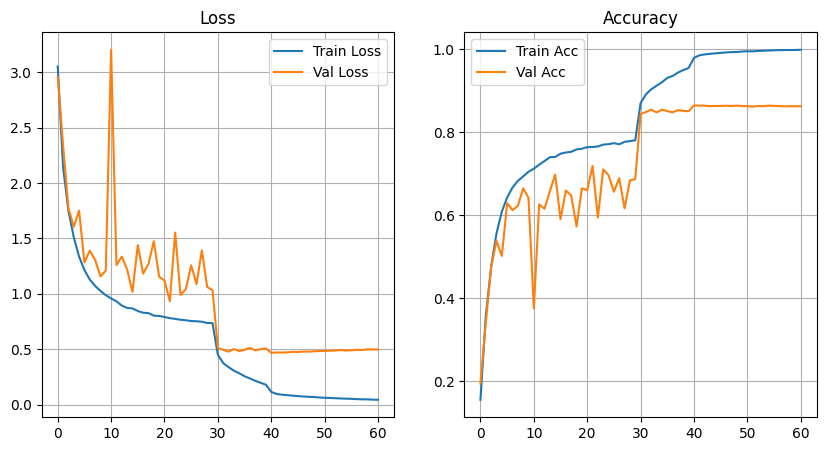


====== X-View Training ======
Epoch 1: Train loss=3.1004, acc=0.147 | Val loss=3.1697, acc=0.215 | time=527.9s
  Best model saved!
Epoch 2: Train loss=2.1168, acc=0.364 | Val loss=1.9951, acc=0.397 | time=243.6s
  Best model saved!
Epoch 3: Train loss=1.7088, acc=0.490 | Val loss=1.6505, acc=0.513 | time=242.9s
  Best model saved!
Epoch 4: Train loss=1.4267, acc=0.576 | Val loss=1.4864, acc=0.557 | time=242.8s
  Best model saved!
Epoch 5: Train loss=1.2622, acc=0.625 | Val loss=1.2058, acc=0.649 | time=242.8s
  Best model saved!
Epoch 6: Train loss=1.1487, acc=0.661 | Val loss=1.6270, acc=0.550 | time=242.9s
Epoch 7: Train loss=1.0821, acc=0.678 | Val loss=1.1781, acc=0.649 | time=242.8s
Epoch 8: Train loss=1.0285, acc=0.695 | Val loss=1.3534, acc=0.612 | time=242.8s
Epoch 9: Train loss=0.9801, acc=0.707 | Val loss=1.5656, acc=0.574 | time=242.8s
Epoch 10: Train loss=0.9510, acc=0.719 | Val loss=1.1822, acc=0.657 | time=242.9s
  Best model saved!
Epoch 11: Train loss=0.9182, acc=0.727

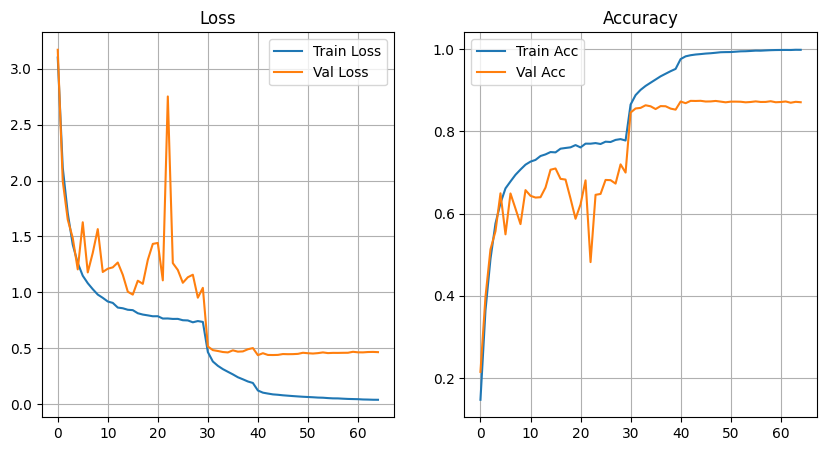

In [ ]:
print("\n====== X-Sub Training ======")
acc_xsub, hist_xsub = run_training(
    trainloader_xsub, valloader_xsub,
    save_path='/content/best_shiftgcn_xsub_72.pth', max_epochs=80, patience=20
)

print("\n====== X-View Training ======")
acc_xview, hist_xview = run_training(
    trainloader_xview, valloader_xview,
    save_path='/content/best_shiftgcn_xview_72.pth', max_epochs=80, patience=20
)
